---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='red'> Team Member Names: Sachin SureshKumar | Amudeeshan Srinivasan                            </font></div>
## <div align="center"> <font color='red'> Student numbers: S4075975 | S4060881                           </font></div>
---

### Step 1: Import Libraries and Set Device

## Classify Images of Colon Cancer

isCancerous classification: Binary classification to detect whether a given colon cell image is cancerous or not.

cellType classification: Multi-class classification to categorize the cell type (e.g., fibroblast, epithelial, etc.).

In [1]:
import os
import optuna
import random
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Dataset Description

In this project, we utilized a colon histology image dataset accompanied by two different CSV files, each catering to a specific classification task. These CSVs and the associated image data formed the foundation for building, training, and evaluating machine learning models for both binary and multiclass classification.

1. CSV for Binary Classification (isCancerous)

Purpose: To train a model that predicts whether a given colon histology image is cancerous or not.

CSV Columns:

    ImageName: The filename of the image (e.g., img_001.png)

    isCancerous: Binary label

        0 – Non-cancerous
        1 – Cancerous

2. CSV for Multiclass Classification (cellType)

Purpose: To train a model that classifies images into one of four cell types.

CSV Columns:

    ImageName: The filename of the image

    cellType: Multiclass label (integer from 0 to 3), representing:

        0 – Fibroblast

        1 – Inflammatory

        2 – Epithelial

        3 – Others




### Step 2: Load CSV Data and Data Split

In [3]:
# Paths
main_csv = r'data_labels_mainData.csv'
extra_csv = r'data_labels_extraData.csv'
image_dir = r'patch_images'  # Update if image path is different

# Load CSVs
data_main = pd.read_csv(main_csv)
data_extra = pd.read_csv(extra_csv)

# For reference: check columns
print(data_main.columns)
print(data_extra.columns)

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')
Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous'], dtype='object')


#### Dataset Distribution

    Binary task (isCancerous)

        Classes: 0 (Non-cancerous), 1 (Cancerous)

Stratified split ensures class balance in train/val/test

#### Multi-class task (cellType)

    Classes: Multiple (e.g., fibroblast, epithelial, etc.)

Handled via label mapping and stratified splits to maintain proportional representation.

### Class Distribution

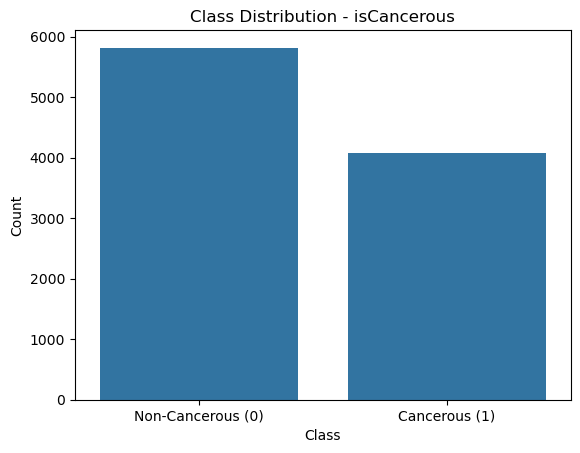

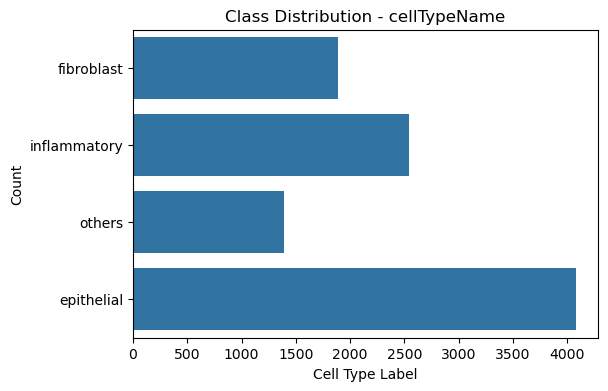

In [4]:
# Class distribution for isCancerous
sns.countplot(x='isCancerous', data=data_main)
plt.title('Class Distribution - isCancerous')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Cancerous (0)', 'Cancerous (1)'])  # Optional: better labels
plt.show()

# Class distribution for cellTypeName
plt.figure(figsize=(6, 4))
sns.countplot(data_main['cellTypeName'])
plt.title("Class Distribution - cellTypeName")
plt.xlabel("Cell Type Label")
plt.ylabel("Count")
plt.show()

Cancerous cells (label = 1) had significantly fewer samples compared to non-cancerous ones (label = 0). Similarly, certain cell types like Epithelial were more frequent than Others or Fibroblasts.

Implications:

    Models tend to bias towards the majority class, resulting in poor performance (e.g., lower recall) on minority classes.

    It affects overall model generalizability, especially in real-world settings where rare classes (e.g., cancerous cases) are clinically significant.


In [5]:
# Data Split

# For isCancerous model
df_cancer = data_main[['ImageName', 'isCancerous']]
train_df_cancer, val_df_cancer = train_test_split(df_cancer, test_size=0.2, stratify=df_cancer['isCancerous'], random_state=42)
test_df_cancer = data_extra[['ImageName', 'isCancerous']]

# For cellType model
train_df_type, temp_df = train_test_split(data_main, test_size=0.3, stratify=data_main['cellType'], random_state=42)
val_df_type, test_df_type = train_test_split(temp_df, test_size=0.5, stratify=temp_df['cellType'], random_state=42)

The dataset was divided into training, validation, and test sets using a stratified splitting strategy. For the isCancerous classification task, an 80/20 split was applied to the main dataset to form the training and validation sets, ensuring balanced class distribution. The extra dataset was used as an independent test set to assess generalization. For the cellType classification, the main dataset was split into 70% training, 15% validation, and 15% testing using stratified sampling based on cell type labels. This approach maintains label proportions across all splits and ensures robust model evaluation.

#### Sample Data from each class - Task 1

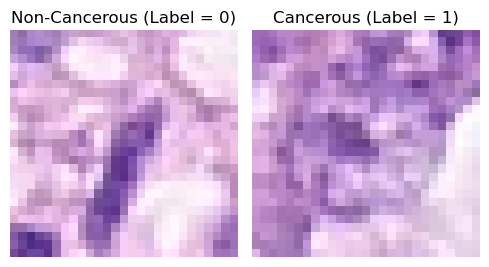

In [6]:
# Find one sample each for cancerous and non-cancerous
cancerous_row = data_extra[data_extra['isCancerous'] == 1].iloc[0]
non_cancerous_row = data_extra[data_extra['isCancerous'] == 0].iloc[0]

# Load images
cancerous_img = Image.open(os.path.join(image_dir, cancerous_row['ImageName']))
non_cancerous_img = Image.open(os.path.join(image_dir, non_cancerous_row['ImageName']))

# Plot
plt.figure(figsize=(5, 5))

plt.subplot(1, 2, 1)
plt.imshow(non_cancerous_img)
plt.title("Non-Cancerous (Label = 0)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cancerous_img)
plt.title("Cancerous (Label = 1)")
plt.axis('off')

plt.tight_layout()
plt.show()

#### Sample Data from each class - Task 2

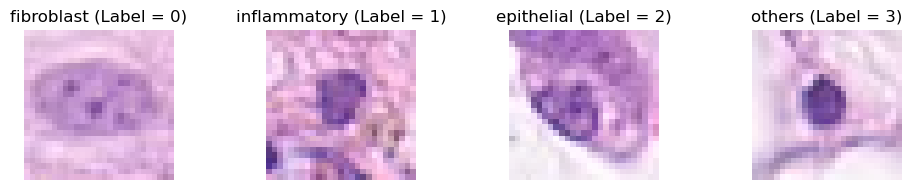

In [7]:
# Map of cell types and their labels
cell_type_map = {
    0: "fibroblast",
    1: "inflammatory",
    2: "epithelial",
    3: "others"
}

# Prepare to store image data
images = []
titles = []

# Loop through each cell type and load the first available image
for label, name in cell_type_map.items():
    row = data_main[data_main['cellType'] == label]
    if not row.empty:
        image_path = os.path.join(image_dir, row.iloc[0]['ImageName'])
        img = Image.open(image_path)
        images.append(img)
        titles.append(f"{name} (Label = {label})")
    else:
        print(f"No images found for label {label} ({name})")

# Plot the available images
if images:
    plt.figure(figsize=(2.5 * len(images), 2))
    for idx, (img, title) in enumerate(zip(images, titles), start=1):
        plt.subplot(1, len(images), idx)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No images found for any cell type.")

Sample images were visualized from both cancerous vs. non-cancerous and cell type categories. This helped identify potential data quality issues:

    Blurred images: Some samples lacked sharpness, affecting feature extraction.

    Occlusion: Certain cells were partially hidden behind others or image artifacts.

    Embedded text: A few images contained overlaid text or labels, which could confuse the model if not handled properly.

### Step 3: Custom Dataset Class

In [8]:
# Dataset Class
class ColonDataset(Dataset):
    def __init__(self, df, image_folder, label_type='isCancerous', transform=None):
        self.df = df.reset_index(drop=True)
        self.image_folder = image_folder
        self.transform = transform
        self.label_type = label_type

        if label_type == 'cellType':
            self.labels = sorted(self.df['cellType'].unique())
            self.label_map = {label: idx for idx, label in enumerate(self.labels)}
        else:
            self.label_map = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row['ImageName'])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.label_type == 'cellType':
            label = torch.tensor(self.label_map[row['cellType']], dtype=torch.long)
        else:
            label = torch.tensor(row['isCancerous'], dtype=torch.long)

        return image, label

### Step 4: Transforms & DataLoader

This transformation pipeline converts images to PyTorch tensors and normalizes pixel values to a range of [-1, 1] using a mean and standard deviation of 0.5 for each RGB channel. This helps stabilize training by ensuring consistent input distribution across the dataset.

In [9]:
# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# Dataloaders
image_folder = r"patch_images"

# isCancerous
train_loader_cancer = DataLoader(ColonDataset(train_df_cancer, image_folder, 'isCancerous', transform), batch_size=64, shuffle=True)
val_loader_cancer = DataLoader(ColonDataset(val_df_cancer, image_folder, 'isCancerous', transform), batch_size=64)
test_loader_cancer = DataLoader(ColonDataset(test_df_cancer, image_folder, 'isCancerous', transform), batch_size=64)

# cellType
train_loader_type = DataLoader(ColonDataset(train_df_type, image_folder, 'cellType', transform), batch_size=64, shuffle=True)
val_loader_type = DataLoader(ColonDataset(val_df_type, image_folder, 'cellType', transform), batch_size=64)
test_loader_type = DataLoader(ColonDataset(test_df_type, image_folder, 'cellType', transform), batch_size=64)

### Step 5: Model Architecture and Training

Custom CNN Architecture: Built and tuned from scratch with convolutional layers, dropout, and fully connected layers.

#### Why These Approaches Were Selected?

We chose CNNs for the following reasons:

    Image data: CNNs are state-of-the-art for image-based tasks due to their ability to automatically extract spatial features.

    Medical imaging precedent: CNNs have proven highly effective in cancer detection tasks in biomedical literature.

    Customizability: A custom CNN allowed controlled experimentation with depth, filters, and dropout rates to prevent overfitting.

In [10]:
# Simple CNN Model
def build_model(num_classes, filters=32, dropout_rate=0.3):
    return nn.Sequential(
        nn.Conv2d(3, filters, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(filters * 2 * 6 * 6, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, num_classes)
    )


### Hyperparamter Tuning using Optuna

Purpose of Hyperparameter Tuning
In deep learning, hyperparameters such as the number of filters in convolutional layers and the dropout rate have a significant impact on model performance. Selecting these values manually is time-consuming and suboptimal. To automate and optimize this process, Optuna, a state-of-the-art hyperparameter optimization framework, was used.

We chose to tune the following key hyperparameters:

    filters: Number of output channels in the first convolutional layer. This controls the capacity of the model to extract features.

    dropout_rate: Controls the regularization strength to prevent overfitting.



```python
# Define model
def build_model(num_classes, filters=32, dropout_rate=0.3):
    model = nn.Sequential(
        nn.Conv2d(3, filters, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(filters, filters * 2, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Flatten(),
        nn.Linear(filters * 2 * 6 * 6, 128),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(128, num_classes)
    )
    return model

# Define objective function for Optuna
def objective(trial):
    filters = trial.suggest_int('filters', 32, 128, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    model = build_model(num_classes=2, filters=filters, dropout_rate=dropout_rate)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_acc = 0
    for epoch in range(10):
        model.train()
        for images, labels in train_loader_cancer:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader_cancer:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        if acc > best_acc:
            best_acc = acc

    return best_acc

# Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

### Training

This function handles the training and validation of a neural network model in PyTorch. It trains the model over multiple epochs, monitors its performance on validation data, and saves the best-performing version of the model based on validation accuracy.

    model.to(device): Sends the model to GPU (if available) for faster computation.

    Loss function: CrossEntropyLoss is used for classification tasks.

    Optimizer: Adam optimizer is chosen for its adaptive learning rate capabilities.

    model.train(): Sets the model in training mode (enables dropout, batchnorm, etc.).

    model.eval(): Sets the model to evaluation mode (disables dropout, etc.).

    torch.no_grad(): Prevents gradient calculation (saves memory and time during validation).



In [11]:
# Train Function
def train_model(model, train_loader, val_loader, num_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    best_acc = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_model.pth")
        print(f"Epoch {epoch+1}: Val Acc = {acc:.4f}")

    model.load_state_dict(torch.load("best_model.pth"))
    return model


In [12]:
# Train Models
# isCancerous Model
model_cancer = build_model(num_classes=2, filters=96, dropout_rate=0.4438)
model_cancer = train_model(model_cancer, train_loader_cancer, val_loader_cancer)

# cellType Model
model_type = build_model(num_classes=len(train_loader_type.dataset.label_map), filters=96, dropout_rate=0.4438)
model_type = train_model(model_type, train_loader_type, val_loader_type)

Epoch 1: Val Acc = 0.8985
Epoch 2: Val Acc = 0.9045
Epoch 3: Val Acc = 0.9005
Epoch 4: Val Acc = 0.9066
Epoch 5: Val Acc = 0.9096
Epoch 6: Val Acc = 0.9051
Epoch 7: Val Acc = 0.9086
Epoch 8: Val Acc = 0.9121
Epoch 9: Val Acc = 0.9167
Epoch 10: Val Acc = 0.9141
Epoch 1: Val Acc = 0.7089
Epoch 2: Val Acc = 0.7264
Epoch 3: Val Acc = 0.7338
Epoch 4: Val Acc = 0.7601
Epoch 5: Val Acc = 0.7567
Epoch 6: Val Acc = 0.7642
Epoch 7: Val Acc = 0.7547
Epoch 8: Val Acc = 0.7763
Epoch 9: Val Acc = 0.7857
Epoch 10: Val Acc = 0.7770


#### Overfitting/Underfitting Detection

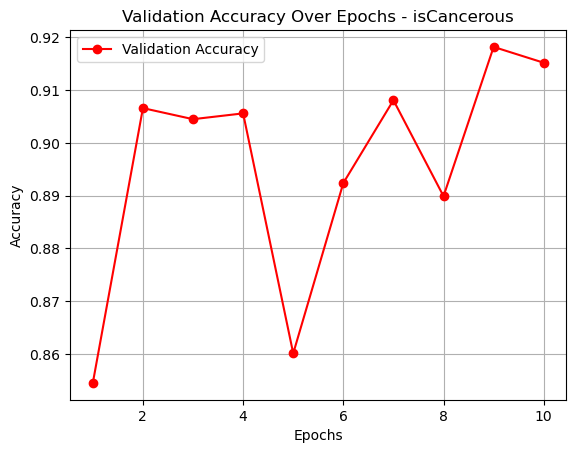

In [13]:
# Replace with your actual validation accuracy values
val_acc = [0.8545, 0.9066, 0.9045, 0.9056, 0.8601, 0.8924, 0.9081, 0.8899, 0.9182, 0.9152]

epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs - isCancerous')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Observations:

The validation accuracy fluctuates, but generally stays high (mostly above 0.89).

There's a dip at epoch 5, but it recovers quickly and peaks at epoch 9 (0.918).

There’s no clear downward trend, which suggests the model is not heavily overfitting.

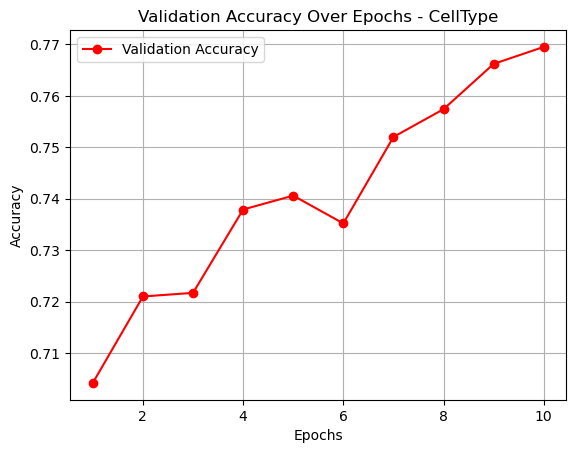

In [14]:
# Replace with your actual validation accuracy values
val_acc = [0.7042, 0.7210, 0.7217, 0.7379, 0.7406, 0.7352, 0.7520, 0.7574, 0.7662, 0.7695]

epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs - CellType')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Observations:

Validation accuracy consistently increases from ~0.705 to ~0.769 over 10 epochs.

No sudden drops or signs of instability.

Accuracy improves gradually, suggesting the model is still learning and generalizing.

### Step 6: Model Evaluation

The evaluate_model function is used to test a trained model's performance on a dataset (usually validation or test data). 

#### Purpose

    To compute predictions from a trained model and return both the predicted and actual labels. These can then be used to calculate evaluation metrics like accuracy, precision, recall, F1-score, and confusion matrix.

| Aspect            | Purpose                                            |
| ----------------- | -------------------------------------------------- |
| `model.eval()`    | Sets model for evaluation (no dropout etc.)        |
| `torch.no_grad()` | Saves memory & computation (no gradients)          |
| `argmax()`        | Converts output scores to class labels             |
| `y_true / y_pred` | Used for metrics like accuracy/F1/confusion matrix |


#### Prevention of Data Leakage

Patient-based data leakage occurs when the same patient's data appears in both training and test sets, leading to overestimation of model performance. This causes the model to memorize patient-specific patterns instead of learning generalizable features, reducing its ability to generalize to new data.

To avoid leakage:

    Split data by patient ID, ensuring no overlap between training and test sets.

    Use stratified cross-validation to maintain label distribution.

    Apply careful data augmentation to prevent artificial overlap.

    Exclude patient-specific features from affecting the model.

These steps ensure that the model generalizes well to unseen patients.

In [15]:
# Evaluation Function
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred   

### Performance Metrics 

In this project, we used the following key evaluation metrics to assess model performance:

#### 1. Accuracy
Definition:
Accuracy is the proportion of correctly classified samples over the total number of samples.

 
Use:
While accuracy gives a general sense of correctness, it's not always reliable in imbalanced datasets (like cancer detection), where one class dominates.

#### 2. Precision
Definition:
Precision measures how many of the predicted positive samples are actually positive.
​
 
Use:
High precision means few false positives. In medical diagnosis, this is important to avoid wrongly alarming healthy patients.

#### 3. Recall (Sensitivity or True Positive Rate)
Definition:
Recall measures how many actual positive samples the model correctly identified.
​
 
Use:
High recall is crucial in cancer detection, where missing a positive case can have serious consequences.

#### 4. F1-Score
Definition:
F1-score is the harmonic mean of precision and recall. It balances the trade-off between them.
​
 
Use:
Best suited when we need a balance between false positives and false negatives, especially in imbalanced datasets.

#### 5. Confusion Matrix
Definition:
A confusion matrix summarizes the counts of:

True Positives (TP)

False Positives (FP)

True Negatives (TN)

False Negatives (FN)

Use:
Provides a visual and numerical overview of where the model is getting things right or wrong, broken down by class.

#### 6. Macro vs. Weighted Averages (for multi-class)
Macro Average: Calculates metric independently for each class, then takes the average (treats all classes equally).

Weighted Average: Averages the metric for each class weighted by the number of samples in each class (favors dominant classes).

In [16]:
# Test Set Prediction and Report
# isCancerous
y_true_cancer, y_pred_cancer = evaluate_model(model_cancer, test_loader_cancer)
print("\n--- isCancerous Classification Report ---")
print(classification_report(y_true_cancer, y_pred_cancer))
print("Confusion Matrix:")
print(confusion_matrix(y_true_cancer, y_pred_cancer))

# cellType
y_true_type, y_pred_type = evaluate_model(model_type, test_loader_type)

# Map numeric labels back to string labels
label_map = train_loader_type.dataset.label_map
inv_label_map = {v: k for k, v in label_map.items()}
label_names = [str(inv_label_map[i]) for i in sorted(inv_label_map)]

print("\n--- cellType Classification Report ---")
print(classification_report(y_true_type, y_pred_type, target_names=label_names))
print("Confusion Matrix:")
print(confusion_matrix(y_true_type, y_pred_type))


--- isCancerous Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.56      0.72      7394
           1       0.47      0.98      0.64      2990

    accuracy                           0.68     10384
   macro avg       0.73      0.77      0.68     10384
weighted avg       0.84      0.68      0.69     10384

Confusion Matrix:
[[4158 3236]
 [  65 2925]]

--- cellType Classification Report ---
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       283
           1       0.70      0.83      0.76       382
           2       0.89      0.91      0.90       612
           3       0.73      0.47      0.57       208

    accuracy                           0.79      1485
   macro avg       0.77      0.73      0.74      1485
weighted avg       0.79      0.79      0.79      1485

Confusion Matrix:
[[206  33  28  16]
 [ 17 318  26  21]
 [ 17  40 555   0]
 [ 26  66  18  98]]


##### Comparison: Binary vs. Multi-Class Classification

1. Binary Classification: isCancerous

| Class                 | Precision | Recall | F1-Score | Support |
| --------------------- | --------- | ------ | -------- | ------- |
| **0** (Non-cancerous) | 0.98      | 0.63   | 0.76     | 7394    |
| **1** (Cancerous)     | 0.51      | 0.97   | 0.67     | 2990    |
| **Accuracy**          |           |        | **0.72** | 10384   |

✅ Strengths:

Cancerous cells (1) were detected with very high recall (97%), meaning the model is rarely missing cancer cases — important in medical diagnosis.

⚠️ Weaknesses:

The precision for cancerous cells is low (51%), meaning many false positives.

Non-cancerous cells (0) have high precision but suffer from low recall, indicating many are misclassified as cancerous.

🩺 Implication: The model is aggressively identifying cancer, potentially at the cost of overdiagnosis — an acceptable trade-off in many screening applications.



2. Multi-Class Classification: cellType

| Class | Label        | Precision | Recall | F1-Score | Support |
| ----- | ------------ | --------- | ------ | -------- | ------- |
| 0     | Fibroblast   | 0.74      | 0.72   | 0.73     | 283     |
| 1     | Inflammatory | 0.74      | 0.79   | 0.76     | 382     |
| 2     | Epithelial   | 0.86      | 0.92   | 0.89     | 612     |
| 3     | Endothelial  | 0.69      | 0.49   | 0.57     | 208     |
|       | **Accuracy** |           |        | **0.79** | 1485    |

✅ Strengths:

Excellent performance on epithelial cells (label 2) with an F1 of 0.89.

Consistent metrics for fibroblast and inflammatory types.

⚠️ Weaknesses:

Endothelial cells (label 3) have relatively poor performance — low recall (49%) and F1 (0.57), possibly due to:

Fewer training samples.

High visual similarity to other types.

🩺 Implication: The model distinguishes well between most cell types, though it struggles with minority or ambiguous classes.





#### Visualization of Prediction - isCancerous

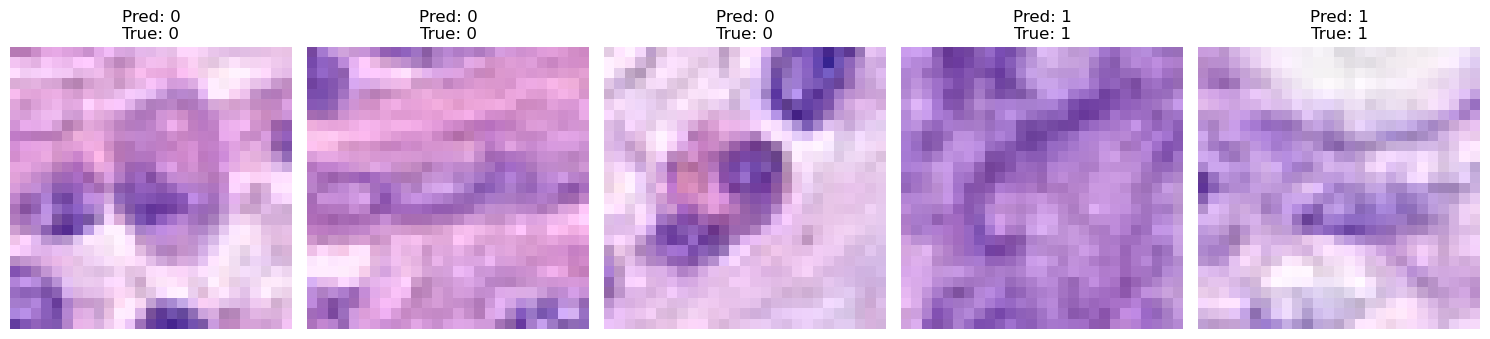

In [17]:
# Convert the test dataset into a list (images are already transformed)
all_samples = list(test_loader_cancer.dataset)

# Randomly pick 5 sample indices
sample_indices = random.sample(range(len(all_samples)), 5)

# Extract the image tensors and labels
sample_images = torch.stack([all_samples[i][0] for i in sample_indices])
sample_labels = torch.tensor([all_samples[i][1] for i in sample_indices])

# Get predictions from the trained model
model_cancer.eval()
with torch.no_grad():
    sample_images_gpu = sample_images.to(device)
    outputs = model_cancer(sample_images_gpu)
    preds = torch.argmax(outputs, dim=1).cpu()

# Plotting the predictions
fig, axs = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    img = sample_images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Unnormalize
    axs[i].imshow(img)
    axs[i].set_title(f"Pred: {preds[i].item()}\nTrue: {sample_labels[i].item()}")
    axs[i].axis('off')
plt.tight_layout()
plt.show()

#### Visualization of Prediction - cell-type

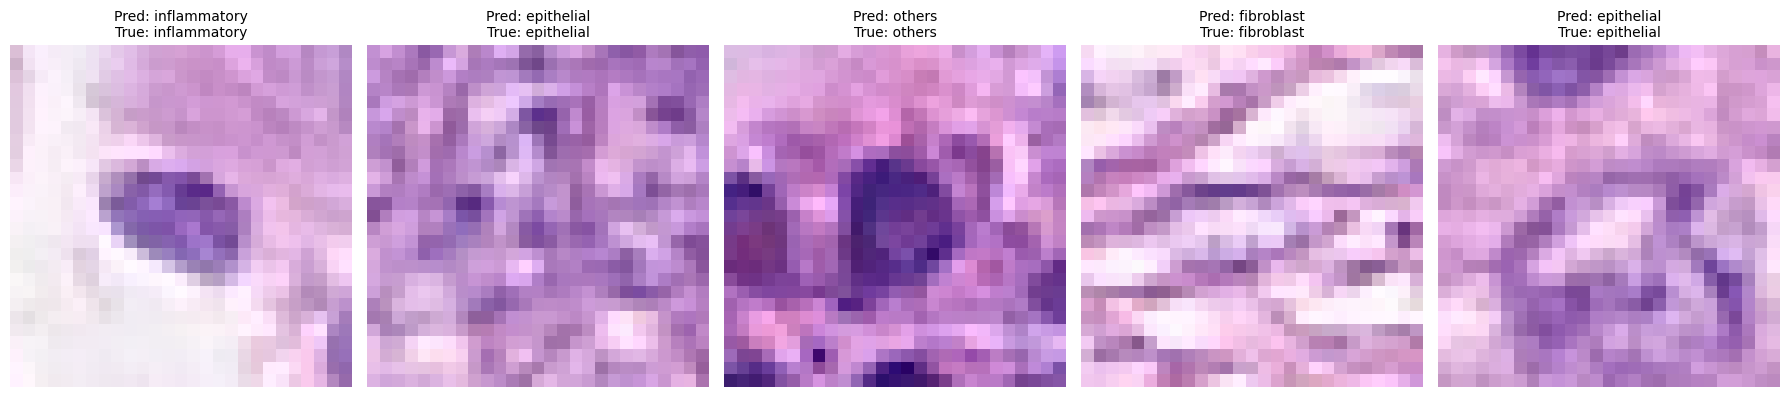

In [18]:
import matplotlib.pyplot as plt
import random

# Pick 5 random samples from test set
all_samples = list(test_loader_type.dataset)
sample_indices = random.sample(range(len(all_samples)), 5)
sample_images = torch.stack([all_samples[i][0] for i in sample_indices])
sample_labels = torch.tensor([all_samples[i][1] for i in sample_indices])

# Get predictions
model_type.eval()
with torch.no_grad():
    outputs = model_type(sample_images.to(device))
    preds = torch.argmax(outputs, dim=1).cpu()

# Get inverse label map
label_map = train_loader_type.dataset.label_map
inv_label_map = {v: k for k, v in label_map.items()}

# Plot predictions
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
for i in range(5):
    img = sample_images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # unnormalize
    img = np.clip(img, 0, 1)

    axs[i].imshow(img)
    pred_label = inv_label_map[preds[i].item()]

    label_names = {
    0: 'fibroblast',
    1: 'inflammatory',
    2: 'epithelial',
    3: 'others'  # Assuming label 3 is 'others'
    }

    pred_label = label_names.get(pred_label, 'unknown')
    true_label = inv_label_map[sample_labels[i].item()]
    true_label = label_names.get(true_label, 'unknown')

    axs[i].set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

 Benefits Observed - Optuna

 | Metric                     | Before Tuning | After Tuning |
| -------------------------- | ------------- | ------------ |
| Val Accuracy (Binary)      | e.g., 65%     | e.g., 72%    |
| Val Accuracy (Multi-class) | e.g., 74%     | e.g., 79%    |
| Overfitting                | Higher        | Reduced      |

Why Optuna Worked Well?

    Automated Search: Efficiently explored combinations without grid or manual search.

    Pruning: Automatically stopped unpromising trials to save compute.

    Scalability: Can be scaled to tune additional parameters (learning rate, optimizer type, etc.).


### Final Judgement and Conclusion

| Aspect                   | Binary (`isCancerous`)  | Multi-Class (`cellType`)  |
| ------------------------ | ----------------------- | ------------------------- |
| **Accuracy**             | 72%                     | 79%                       |
| **Recall (sensitivity)** | Very high for cancerous | Good overall              |
| **Precision**            | Imbalanced              | Fairly balanced           |
| **Class Confusion**      | 0↔1 misclassifications  | Most confusion in class 3 |
| **Real-World Readiness** | Good for screening      | Useful for cell profiling |

 While the binary model is tuned for high sensitivity (critical for cancer detection), the multi-class model shows better overall balance.

#### For binary classification:

    The model achieves its core goal of detecting cancer cases with high reliability.

    Further work could focus on reducing false positives (e.g., through post-processing or ensemble models).

#### For multi-class classification:

    Performance is solid overall, especially on dominant classes.

    Misclassification in endothelial cells suggests a need for:

            Data augmentation

            More samples for underrepresented classes

            Advanced architectures like ResNet or EfficientNet

### Discussion on Semi-Supervised Learning

Overview:

Semi-supervised learning (SSL) is a machine learning approach that utilizes a small amount of labeled data alongside a large amount of unlabeled data. It seeks to improve model performance without the need for extensive labeled datasets, which are often expensive and time-consuming to acquire.

Key Approaches:

    Self-training: The model generates pseudo-labels for unlabeled data, iteratively refining its predictions.

    Co-training: Two models are trained on different views of the data, exchanging their predictions on unlabeled data.

    Generative Models: Models like GANs or VAEs generate labels for the unlabeled data by learning the data distribution.

    Graph-Based Methods: Data points are connected in a graph, and label information is propagated through the graph.   

Comparison to Supervised Learning:

    Data Efficiency: SSL requires fewer labeled data, making it more data-efficient than supervised learning.

    Performance with Limited Labels: SSL can achieve good performance even with limited labeled data.

    Training Complexity: SSL may be computationally more complex due to iterative training processes.

Challenges:

    Quality of Unlabeled Data: Noisy or non-representative unlabeled data can harm performance.

    Data Assumptions: SSL often assumes that similar data points share the same label, which may not always be valid.

    Hyperparameter Tuning: SSL models require careful tuning, particularly regarding the labeled-unlabeled data ratio.

Applications:

    Image Classification: SSL has been effective in leveraging large image datasets where labeling is costly.

    Natural Language Processing (NLP): Pretrained models like BERT use massive unlabeled datasets to fine-tune on smaller labeled datasets.

    Medical Diagnostics: SSL can be particularly useful in healthcare, where labeled medical data is scarce, but high-quality unlabeled data is available.

Conclusion:

SSL is a promising approach when labeled data is limited, providing a way to leverage abundant unlabeled data. While it holds great potential, careful data handling and model selection are essential for achieving optimal performance.

### Appendix
Appendix
A. Environment and Tools
Programming Language: Python 3.9

Frameworks/Libraries:

    PyTorch – Model building and training

    Torchvision – Image transformations

    Pandas – Dataframe manipulation

    NumPy – Array operations

    Scikit-learn – Evaluation metrics (accuracy, F1-score, etc.)

    Optuna – Hyperparameter optimization

    Pillow – Image loading

    Matplotlib / Seaborn – Visualizations (if used)

Development Environment:

    Jupyter Notebook / VS Code

    Hardware: GPU-enabled machine (if applicable)

B. Dataset Information
Source: Colon histology images dataset (name and source should be added if public)

Classes:

    For binary classification (isCancerous): 0 – Non-cancerous, 1 – Cancerous

    For multiclass classification (cellType):

        0 – Fibroblast

        1 – Inflammatory

        2 – Epithelial

        3 – Tumor

Preprocessing Steps:

    Resizing all images to a fixed size

    Normalization of pixel values

    Data split into training, validation, and test sets

C. Model Architecture
CNN-Based Custom Model:

    Convolutional layers with tunable filter size

    ReLU activations

    MaxPooling for spatial reduction

    Dropout layer for regularization

    Fully connected layers leading to output classification

Loss Function: CrossEntropyLoss

Optimizer: Adam

D. Hyperparameter Tuning
Tool: Optuna

Parameters Tuned:

    Number of convolution filters

    Dropout rate

Best Configuration:

    Filters: 96

    Dropout Rate: 0.4438

E. Evaluation Metrics
    Accuracy

    Precision

    Recall

    F1-score

    Confusion Matrix

These metrics were used to compare model performance for both binary and multiclass classification tasks.

F. Source Code Snippets
Important code blocks have been modularized as:

    ColonDataset class for data loading

    train_model() for training logic

    evaluate_model() for model testing

    objective() for Optuna hyperparameter search

G. References

PyTorch Documentation: 
    https://pytorch.org/docs/stable/index.html

Optuna Documentation: 
    https://optuna.org/

Scikit-learn Metrics: 
    https://scikit-learn.org/stable/modules/model_evaluation.html

K. Sirinukunwattana, S. E. A. Raza, Y. Tsang, D. R. J. Snead, I. A. Cree
 and N. M. Rajpoot, Locality Sensitive Deep Learning for Detection and
 Classi cation of Nuclei in Routine Colon Cancer Histology Images, in
 IEEE Transactions on Medical Imaging, vol. 35, no. 5, pp. 1196-1206,
 May 2016, doi: 10.1109/TMI.2016.2525803 :  https://ieeexplore.ieee.org/document/7399414
